If working with Google Colab run the following cell (otherwise can be ignored)

In [12]:
!pip install pytorch_fid

In [13]:
import torch
import random
import numpy as np
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
from PIL import Image
import os
import shutil
import pytorch_fid
import gzip
from pytorch_fid.inception import InceptionV3
from pytorch_fid.fid_score import calculate_frechet_distance, compute_statistics_of_path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Fashion MNIST Dataset
For more information:
https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [14]:
mnist_train = MNIST("./data", train=True, download=True,
                    transform=torchvision.transforms.ToTensor())
mnist_test = MNIST("./data", train=False, download=True,
                  transform=torchvision.transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=32, shuffle=False)

This is the data we are working with (some examples)

Train dataset size: 60000
Test dataset size: 10000
Image shape: torch.Size([1, 28, 28])
Label of first image: 5


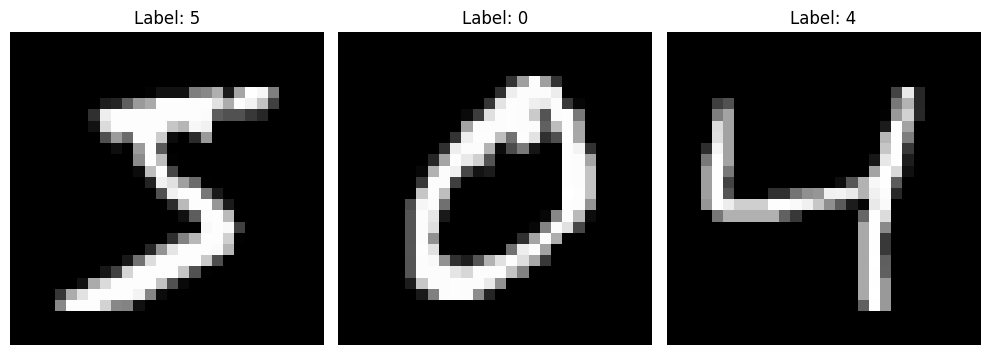

In [15]:
import matplotlib.pyplot as plt

print(f"Train dataset size: {len(mnist_train)}")
print(f"Test dataset size: {len(mnist_test)}")
print(f"Image shape: {mnist_train[0][0].shape}")  # (1, 28, 28) = 1 Channel (grey), 28x28 Pixel
print(f"Label of first image: {mnist_train[0][1]}")

# Show 3 example images
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

for i in range(3):
    image, label = mnist_train[i]
    axs[i].imshow(image.squeeze(), cmap="gray")
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Model architecture
- Encoder
- Decoder

We make use of the Reparameterization trick to enable Backpropagation (https://en.wikipedia.org/wiki/Reparameterization_trick)

In [16]:
class VAE(nn.Module):
    def __init__(self, encoding_dim):
        super(VAE, self).__init__()
        self.encoding_dim = encoding_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 1x28x28 -> 64x14x14
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 64x14x14 -> 128x7x7
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim * 2)  # mu and log_var
        )
        # Decoder
        self.decoder_input = nn.Linear(encoding_dim, 128)
        self.decoder = nn.Sequential(
            nn.Linear(128, 64 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 64x7x7 -> 32x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # 32x14x14 -> 1x28x28
            nn.Sigmoid() # Values between 0 and 1
        )

    def encode(self, x):
        x = self.encoder(x)
        mu, log_var = x.split(self.encoding_dim, dim=1)
        return mu, log_var

    # Reparameterization trick
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.decoder_input(z)
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

## Training & Testing Functions

In [21]:
def train_vae_epoch(model, dataloader, optimizer, recon_loss_fn):
    model.train()
    total_loss, recon_loss, kl_loss = 0, 0, 0

    for features, _ in dataloader:
        features = features.to(device)
        optimizer.zero_grad()
        recon, mu, log_var = model(features) # Use mu and log_var for KL divergence loss

        batch_size = features.size(0)
        
        # Reconstruction loss
        recon_loss_batch = recon_loss_fn(recon, features) / batch_size # Update!!!

        # KL divergence loss
        kl_loss_batch = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / batch_size # Update!!!

        # Combined loss
        loss = recon_loss_batch + kl_loss_batch

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        recon_loss += recon_loss_batch.item()
        kl_loss += kl_loss_batch.item()

    return total_loss / len(dataloader.dataset), recon_loss / len(dataloader.dataset), kl_loss / len(dataloader.dataset)

## Testing Function using FID Score
For more information: https://en.wikipedia.org/wiki/Fréchet_inception_distance

In [22]:
import torchvision.transforms as T

fid_preprocess = T.Compose([
    T.Resize((299, 299)),
    T.Lambda(lambda x: x.expand(3, -1, -1)),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def preprocess_batch_for_fid(batch):
    return torch.stack([fid_preprocess(img) for img in batch])

def extract_inception_features(images, model, batch_size=64):
    features = []
    model.eval()
    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size].to(device)
            output = model(batch)[0]
            output = output.squeeze(-1).squeeze(-1).cpu()
            features.append(output)
    return torch.cat(features, dim=0).numpy()

def test_vae_from_sampling(model, latent_dim, fid_model, n_images=1000):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_images, latent_dim).to(device)
        generated = model.decode(z).cpu()

    real_images = torch.stack([mnist_test[i][0] for i in range(n_images)])

    real_pre = preprocess_batch_for_fid(real_images)
    gen_pre = preprocess_batch_for_fid(generated)

    real_feats = extract_inception_features(real_pre, fid_model)
    gen_feats = extract_inception_features(gen_pre, fid_model)

    mu_r, sigma_r = real_feats.mean(axis=0), np.cov(real_feats, rowvar=False)
    mu_g, sigma_g = gen_feats.mean(axis=0), np.cov(gen_feats, rowvar=False)

    return calculate_frechet_distance(mu_r, sigma_r, mu_g, sigma_g)

## Further Testing Function

In [23]:
def show_reconstructions(model, dataset, n=10):
    model.eval()
    fig, axs = plt.subplots(2, n, figsize=(n*2.5, 5))

    with torch.no_grad():
        for i in range(n):
            image, _ = dataset[i]
            image_input = image.unsqueeze(0).to(device)  # (1, 1, 28, 28)
            recon, _, _ = model(image_input)

            axs[0, i].imshow(image.squeeze(0), cmap='gray')
            axs[0, i].set_title("Original")
            axs[0, i].axis('off')

            axs[1, i].imshow(recon.squeeze().cpu(), cmap='gray')
            axs[1, i].set_title("Reconstructed")
            axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

## Parameter & Configurations

In [24]:
latent_dim = 16
model = VAE(encoding_dim=latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
recon_loss_fn = nn.MSELoss(reduction='sum')
epochs = 20

## Training

In [ ]:
for epoch in range(epochs):
  total_loss, recon_loss, kl_loss = train_vae_epoch(model, train_loader, optimizer, recon_loss_fn)
  print(f"Epoch {epoch + 1}/{epochs}, Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}")

## Testing (FID Score)

In [ ]:
fid_model = InceptionV3([InceptionV3.BLOCK_INDEX_BY_DIM[2048]]).to(device)
fid_model.eval()

fid_sample = test_vae_from_sampling(model, latent_dim, fid_model)
print(f"FID Score (from sampled images): {fid_sample:.4f}")

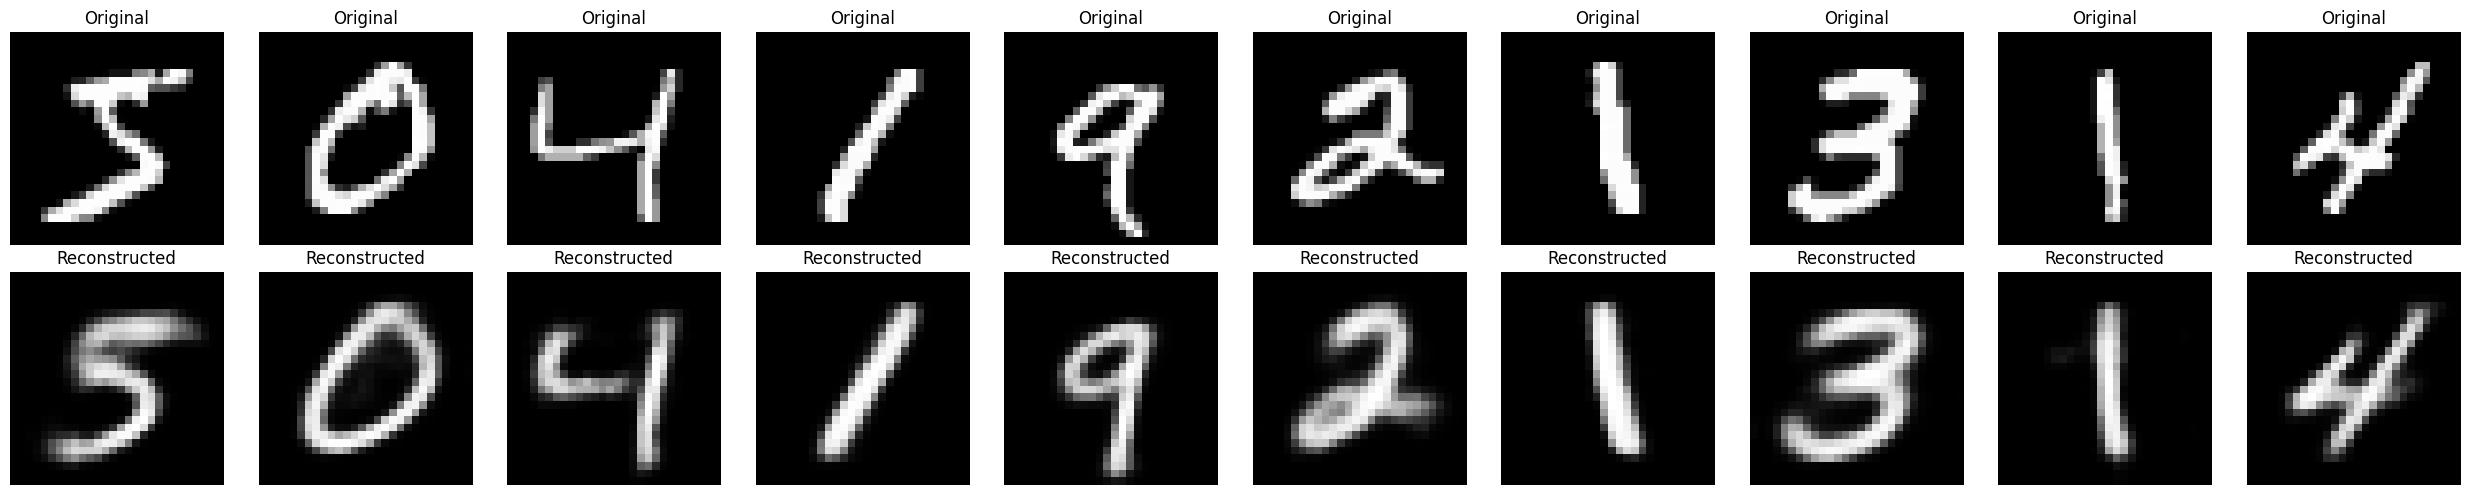

In [26]:
show_reconstructions(model, mnist_train)